In [1]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
! cd /content/drive/MyDrive

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
data=pd.read_csv(r"/content/drive/MyDrive/RATING_DATA8")


In [3]:
data.head()

,Unnamed: 0,review,rating
0,0,Mobile fail,3
1,1,More hanging problem\nCamera quality is not go...,3
2,2,Not for Good,3
3,3,Hanging,3
4,4,"This mobile is purely for normal use, I don't ...",3


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9847 entries, 0 to 9846
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  9847 non-null   int64 
 1   review      9842 non-null   object
 2   rating      9847 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 230.9+ KB


In [5]:
data.shape

(9847, 3)

In [6]:
data.isna().sum()

Unnamed: 0    0
review        5
rating        0
dtype: int64

In [7]:
data=data.dropna()

In [8]:
data.isna().sum()

Unnamed: 0    0
review        0
rating        0
dtype: int64

In [9]:
data.shape

(9842, 3)

In [10]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
import string
from nltk.stem import WordNetLemmatizer
lematizer=WordNetLemmatizer()
def cleaning(df, stop_words):

  def ref(x):
    a=re.sub('[^a-zA-Z]', ' ',x)
    return a   
    
  df['review']=df['review'].apply(ref) 
  #converting to lowercase
  df['review'] = df['review'].apply(lambda x:
  ' '.join(x.lower() for x in x.split()))
  # Replacing the digits/numbers
  df['review'] = df['review'].str.replace('d', ''
  )
  # Removing stop words
  df['review'] = df['review'].apply(lambda x:
  ' '.join(x for x in x.split() if x not in stop_words))
  # removing punctuation
  df['review'] = df['review'].apply(lambda x:
  ' '.join(x for x in x.split() if x not in string.punctuation))
  # Lemmatization
  df['review'] = df['review'].apply(lambda x:' '.join([Word(x).lemmatize() for x in x.split()]))
  return df
stop_words = stopwords.words('english')
data = cleaning(data, stop_words)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [12]:
data.head()

,Unnamed: 0,review,rating
0,0,mobile fail,3
1,1,hanging problem camera quality goo pre install...,3
2,2,goo,3
3,3,hanging,3
4,4,mobile purely normal use recommen heavy user c...,3


data['review'][5778]

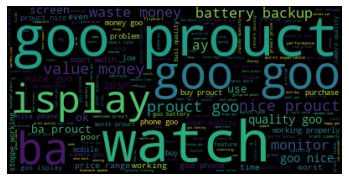

In [13]:
common_words=''
for i in data.review:
    
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [14]:
tokenizer = Tokenizer(num_words=3000, split=' ')
tokenizer.fit_on_texts(data['review'].values)
X = tokenizer.texts_to_sequences(data['review'].values)
X = pad_sequences(X,maxlen=100)
X

array([[   0,    0,    0, ...,    0,   26, 1574],
       [   0,    0,    0, ..., 1226,  915,   62],
       [   0,    0,    0, ...,    0,    0,    1],
       ...,
       [   0,    0,    0, ...,   60,  127,   21],
       [   0,    0,    0, ...,   11,  816,    2],
       [   0,    0,    0, ...,    0,   16,    6]], dtype=int32)

In [15]:
X[5779].shape

(100,)

In [16]:
X.shape

(9842, 100)

In [17]:
model = Sequential()
model.add(Embedding(5000,100, input_length = X.shape[1]))# 100
model.add(SpatialDropout1D(0.3))
model.add(LSTM(150, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(5,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 150)               150600    
                                                                 
 dense (Dense)               (None, 5)                 755       
                                                                 
Total params: 651,355
Trainable params: 651,355
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
est=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

In [19]:
y=pd.get_dummies(data['rating'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [20]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [29]:
batch_size=64
history=model.fit(X_train, y_train, epochs = 30, batch_size=batch_size, verbose = 1,validation_data=(X_test,y_test),callbacks=[est])


Epoch 1/30
108/108 [==============================] - 47s 434ms/step - loss: 0.6424 - accuracy: 0.7612 - val_loss: 0.7888 - val_accuracy: 0.7233
Epoch 2/30
108/108 [==============================] - 45s 413ms/step - loss: 0.5953 - accuracy: 0.7796 - val_loss: 0.7961 - val_accuracy: 0.7250
Epoch 3/30
108/108 [==============================] - 45s 417ms/step - loss: 0.5711 - accuracy: 0.7814 - val_loss: 0.8001 - val_accuracy: 0.7254
Epoch 4/30
108/108 [==============================] - 45s 413ms/step - loss: 0.5470 - accuracy: 0.7894 - val_loss: 0.8118 - val_accuracy: 0.7294
Epoch 5/30
108/108 [==============================] - 44s 408ms/step - loss: 0.5338 - accuracy: 0.7956 - val_loss: 0.8271 - val_accuracy: 0.7328
Epoch 6/30
108/108 [==============================] - 44s 407ms/step - loss: 0.5237 - accuracy: 0.8030 - val_loss: 0.8253 - val_accuracy: 0.7298
Epoch 6: early stopping


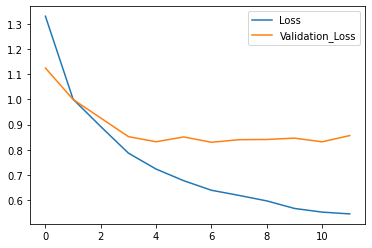

In [22]:
import seaborn as sns
ax=plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Validation_Loss')
plt.legend()
plt.show()

In [23]:
_,train_acc=model.evaluate(X_train,y_train,verbose=0)
_,test_acc=model.evaluate(X_test,y_test,verbose=0)


In [24]:
print(train_acc)
print(test_acc)

0.7863260507583618
0.7185912728309631


In [30]:
model.save('RatingPred.h5')
